In [1]:
import warnings
from tqdm import tqdm
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
import catboost as cab
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,precision_recall_fscore_support,roc_curve,auc,roc_auc_score
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import gc
from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

#from featexp import get_univariate_plots#用于特征筛选，需要先安装featexp
warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif']=['Simhei']
plt.rcParams['axes.unicode_minus']=False
import json
import jieba

C:\ProgramData\Anaconda3\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
base_info=pd.read_csv('train/base_info.csv')#企业的基本信息
annual_report_info=pd.read_csv('train/annual_report_info.csv')#企业的年报基本信息
tax_info=pd.read_csv('train/tax_info.csv')#企业的纳税信息
change_info=pd.read_csv('train/change_info.csv')#变更信息
news_info=pd.read_csv('train/news_info.csv')#舆情信18
other_info=pd.read_csv('train/other_info.csv')#其它信息
entprise_info=pd.read_csv('train/entprise_info.csv')#企业标注信息{0: 13884, 1: 981}
entprise_evaluate=pd.read_csv('entprise_evaluate.csv')#未标注信息

In [3]:
entprise_train = pd.read_csv('train/entprise_info.csv',engine='python')
base_info = pd.read_csv('train/base_info.csv',engine='python',encoding='utf-8')
entprise_test = pd.read_csv('entprise_evaluate.csv')
reccap_predict = pd.read_csv('reccap_predict.csv')['reccap']
empnum_predict = pd.read_csv('empnum_predict.csv')['empnum']

In [4]:
#change_info
change_info_clean=change_info.drop(['bgrq','bgq','bgh'],axis=1)
change_info_clean = change_info_clean.groupby('id',sort=False).agg('mean')
change_info_clean=pd.DataFrame(change_info_clean).reset_index()
#other_info
#空值大于0.5的列都删除掉
buf_group = other_info.groupby('id',sort=False).agg('mean')
other_info_clean=pd.DataFrame(buf_group).reset_index()
other_info_clean=other_info_clean.fillna(-1)
other_info_clean = other_info_clean.groupby('id',sort=False).agg('mean')
other_info_clean=pd.DataFrame(other_info_clean).reset_index()
#news_info
news_info_clean=news_info.drop(['public_date'],axis=1)
#对object类型进行编码
news_info_clean['positive_negtive']=news_info_clean['positive_negtive'].fillna("中立")
#
dic={}
cate=news_info_clean.positive_negtive.unique()
for i in range(len(cate)):
    dic[cate[i]]=i
#
news_info_clean['positive_negtive']=news_info_clean['positive_negtive'].map(dic)
news_info_clean = news_info_clean.groupby('id',sort=False).agg('mean')
news_info_clean=pd.DataFrame(news_info_clean).reset_index()
#处理annual_report_info的数据
#空值大于0.5的列都删除掉
annual_report_info_clean=annual_report_info.dropna(thresh=annual_report_info.shape[0]*0.5,how='all',axis=1)
#对object类型进行编码
annual_report_info_clean['BUSSTNAME']=annual_report_info_clean['BUSSTNAME'].fillna("无")
dic = {'无':-1,'开业':0, '歇业':1, '停业':2, '清算':3}
#
annual_report_info_clean['BUSSTNAME']=annual_report_info_clean['BUSSTNAME'].map(dic)
annual_report_info_clean = annual_report_info_clean.groupby('id',sort=False).agg('mean')
annual_report_info_clean=pd.DataFrame(annual_report_info_clean).reset_index()
#处理tax数据
tax_info_clean=tax_info.copy()
tax_info_clean['START_DATE']=pd.to_datetime(tax_info_clean['START_DATE'])
tax_info_clean['END_DATE']=pd.to_datetime(tax_info_clean['END_DATE'])
tax_info_clean['gap_day']=(tax_info_clean['END_DATE']-tax_info_clean['START_DATE']).dt.total_seconds()//3600//24
tax_info_clean=tax_info_clean.drop(['START_DATE','END_DATE'],axis=1)
tax_info_clean['TAX_CATEGORIES']=tax_info_clean['TAX_CATEGORIES'].fillna("无")#17 unique
tax_info_clean['TAX_ITEMS']=tax_info_clean['TAX_ITEMS'].fillna("无")#275 TAX_ITEMS
#对object类型进行编码
dic={}
cate=tax_info_clean.TAX_CATEGORIES.unique()
for i in range(len(cate)):
    dic[cate[i]]=i
tax_info_clean['TAX_CATEGORIES']=tax_info_clean['TAX_CATEGORIES'].map(dic)
#
dic={}
cate=tax_info_clean.TAX_ITEMS.unique()
for i in range(len(cate)):
    dic[cate[i]]=i
tax_info_clean['TAX_ITEMS']=tax_info_clean['TAX_ITEMS'].map(dic)
tax_info_clean['income']=tax_info_clean['TAX_AMOUNT']/tax_info_clean['TAX_RATE']
#
tax_info_clean = tax_info_clean.groupby('id',sort=False).agg('mean')
tax_info_clean=pd.DataFrame(tax_info_clean).reset_index()
#税额分箱
tax_info_clean['TAX_AMOUNT']=tax_info_clean['TAX_AMOUNT'].fillna(tax_info_clean['TAX_AMOUNT'].median())
tax_info_clean['bucket_TAX_AMOUNT']=pd.qcut(tax_info_clean['TAX_AMOUNT'], 10, labels=False,duplicates='drop')
print('finished .............')

finished .............


In [ ]:
def stopwordslist():
    stopwords = [line.strip() for line in open('cn_stopwords.txt',encoding='UTF-8').readlines()]
    return stopwords
# 创建一个停用词列表
stopwords = stopwordslist()
stopwords+=['、', '；', '，', '）','（']
#
train_df_scope=base_info.merge(entprise_train)[['id','opscope','label']]
test_df_scope=base_info[base_info['id'].isin(entprise_test['id'].unique().tolist())]
test_df_scope=test_df_scope.reset_index(drop=True)[['id','opscope']]
str_label_0=''
str_label_1=''
for index,name,opscope,label in train_df_scope.itertuples():
    # 结巴分词
    seg_text = jieba.cut(opscope.replace("\t", " ").replace("\n", " "))
    outline = " ".join(seg_text)
    out_str=""
    for per in outline.split():
        if per not in stopwords: 
            out_str += per
            out_str+=" "
    if label==0:
        str_label_0+=out_str
    else:
        str_label_1+=out_str
corpus=[str_label_0,str_label_1]
vectorizer=CountVectorizer()#该类会将文本中的词语转换为词频矩阵，矩阵元素a[i][j] 表示j词在i类文本下的词频
transformer=TfidfTransformer()#该类会统计每个词语的tf-idf权值
tfidf=transformer.fit_transform(vectorizer.fit_transform(corpus))#第一个fit_transform是计算tf-idf，第二个fit_transform是将文本转为词频矩阵
word=vectorizer.get_feature_names()#获取词袋模型中的所有词语总共7175个词语
weight=tfidf.toarray()#将(2, 7175)tf-idf矩阵抽取出来，元素a[i][j]表示j词在i类文本中的tf-idf权重
# for i in range(len(weight)):#打印每类文本的tf-idf词语权重，第一个for遍历所有文本，第二个for便利某一类文本下的词语权重
#     #
#     for j in range(len(word)):
#         print(word[j],weight[i][j])
#下面将会根据tfidi算出来的权重将经营范围的文本特征转换为数值(利用weight[1,:]也即各个词语在第二类(违法类中所占据的权重之和))
illegal_word_weights={}
for i in range(len(word)):
    illegal_word_weights[word[i]]=weight[1][i]
tfidi_opscope=[]
for index,name,opscope in base_info[['id','opscope']].itertuples():
    seg_text = jieba.cut(opscope.replace("\t", " ").replace("\n", " "))
    outline = " ".join(seg_text)
    tfidi_frt=0
    for per in outline.split():
        if per in illegal_word_weights: 
            tfidi_frt+=illegal_word_weights[per]
    tfidi_opscope.append(tfidi_frt)
base_info['tfidif_opscope']=tfidi_opscope
print('对opscope提取tfidif特征完毕..........')

In [6]:
entprise = pd.concat([entprise_train,entprise_test])
data = pd.merge(entprise,base_info,on='id')
data.drop(['ptbusscope','midpreindcode','score'],axis=1,inplace=True)

In [7]:
data=data.merge(annual_report_info_clean,how='outer')
data=data.merge(tax_info_clean,how='outer')
data=data.merge(change_info_clean,how='outer')
data=data.merge(news_info_clean,how='outer')
data=data.merge(other_info_clean,how='outer')

In [8]:
data['id_feature'] = data['id'].apply(lambda x:x[:16])
from sklearn.preprocessing import LabelEncoder
le1 = LabelEncoder()
data['id_feature'] =le1.fit_transform(data['id_feature'])

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24865 entries, 0 to 24864
Data columns (total 64 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  24865 non-null  object 
 1   label               14865 non-null  float64
 2   oplocdistrict       24865 non-null  int64  
 3   industryphy         24865 non-null  object 
 4   industryco          24864 non-null  float64
 5   dom                 24865 non-null  object 
 6   opscope             24865 non-null  object 
 7   enttype             24865 non-null  int64  
 8   enttypeitem         16651 non-null  float64
 9   opfrom              24865 non-null  object 
 10  opto                8825 non-null   object 
 11  state               24865 non-null  int64  
 12  orgid               24865 non-null  int64  
 13  jobid               24865 non-null  int64  
 14  adbusign            24865 non-null  int64  
 15  townsign            24865 non-null  int64  
 16  regt

In [10]:
data['enttypeitem'] = data['enttypegb']//10*10
data['enttypeminu'] = data['enttypegb']
data['regcap'] = data['regcap'].fillna(data['regcap'].mean())
data['reccap'] = reccap_predict
data['empnum'] = empnum_predict
data['reccap'] = data['reccap']
data['opform'].fillna(10,inplace=True)
data['opform'] = data['opform'].astype(str)
from sklearn.preprocessing import LabelEncoder
labelencoder1 = LabelEncoder()
labelencoder2 = LabelEncoder()
labelencoder3 = LabelEncoder()
labelencoder4 = LabelEncoder()
data['opform'] = labelencoder1.fit_transform(data['opform'])
data['oploc'] = labelencoder2.fit_transform(data['oploc'])
data['industryphy'] = labelencoder3.fit_transform(data['industryphy'])
data['oplocdistrict'] = labelencoder4.fit_transform(data['oplocdistrict'])
def opto_process(x):
    if len(x)>3:
        return x[:4]
    else:
        return x
data['opfrom'] = data['opfrom'].map(lambda x:x[:4])
data['opto'].fillna('nan',inplace=True)
data['opto'] = data['opto'].map(opto_process)
data['opfrom'] = data['opfrom'].astype(int)
data['opto'] = data['opto'].astype(float)
data['industryco'] = data['industryco'].fillna(data['industryco'].mean())
data.loc[data['opto'].isnull(),"opto"] = data[data['opto'].isnull()]['opfrom']+50.0
data['enttpe_year'] = data['opfrom'] - data['opto']
data['opscope'] = data['opscope'].apply(lambda x:x.replace("、","/").replace("；","/").replace("，","/").replace("。","/"))
data['opscope'] = data['opscope'].apply(lambda x:x.replace("（","/").replace("）","/").replace("，","/").replace("。","/"))
data['opscope_1'] = data['opscope'].apply(lambda x:x.split("/"))
data['opscope_feature'] = data['opscope'].apply(lambda x:x.split("/")[0][-2:])
le2 = LabelEncoder()
data['opscope_feature'] = le2.fit_transform(data['opscope_feature'])
# import jieba
# data['opscope_1'] = data['opscope'].apply(lambda x:jieba.lcut(x,cut_all=True))
# from collections import Counter
# def jieba_func(x):
#     str1 = list(Counter(x).keys())[0]
#     str2 = list(Counter(x).keys())[1]
#     count = str1+str2
#     return count
# data['count_opscope'] = data['opscope'].apply(lambda x:jieba_func(x))
# le6 = LabelEncoder()
data['opscope_length'] = data['opscope_1'].apply(lambda x:len(x))
# data['opscope'] = data['opscope'].apply(lambda x:x.split('/')[-2:])
# data['opscope_label'] = le6.fit_transform(data['count_opscope'])

In [11]:
data['opscope']

0        实业投资/创业投资/投资咨询/不得从事经纪//涉及前置许可的除外///依法须经批准的项目/经...
1                                       摄影/摄像/相册冲印制作/司仪服务/
2        OLED显示屏制造/LED电子屏销售/发光二极管/LED/芯片制造设备制造/发光二极管/LE...
3        新能源科技领域内的技术研发/技术服务/金属材料/除贵金属//煤炭/铁精粉/矿产品/钢材/化工...
4                    汽车维修/保养服务/依法须经批准的项目/经相关部门批准后方可开展经营活动/
                               ...                        
24860    化妆品/日用百货/一类医疗器械/婴幼儿用品/服装服饰销售/健康信息咨询/除医疗//广告设计/...
24861    生物技术咨询/研发/转让/保健食品批发/食品流通许可证有效期至2017年8月3日//化妆品/...
24862    环保领域内的技术开发/技术咨询/技术服务/技术转让/环保设备的设计/生产/销售/镁合金/铝合...
24863    电子产品/电子元器件/线束/电子连接器/五金/电线/电缆研发/生产/销售/自营和代理各类商品...
24864    资产管理/投资管理/投资咨询/证券/期货咨询除外//财务咨询/企业管理咨询/以上咨询均除经纪...
Name: opscope, Length: 24865, dtype: object

In [12]:
def bucket(name,bucket_len):
    gap_list=[data[name].quantile(i/bucket_len) for i in range(bucket_len+1)]
    len_data=len(data[name])
    new_col=[]
    for i in data[name].values:
        for j in range(len(gap_list)):
            if gap_list[j]>=i:
                encode=j
                break
        new_col.append(encode)
    return new_col
#注册资本_实缴资本
data['regcap_reccap']=data['regcap']-data['reccap']
#注册资本分桶
data['regcap']=data['regcap'].fillna(data['regcap'].median())
data['bucket_regcap']=bucket('regcap',5)
#实缴资本分桶
data['reccap']=data['reccap'].fillna(data['reccap'].median())
data['bucket_reccap']=bucket('reccap',5)
#注册资本_实缴资本分桶
data['regcap_reccap']=data['regcap_reccap'].fillna(data['regcap_reccap'].median())
data['bucket_regcap_reccap']=bucket('regcap_reccap',5)
print('分桶完毕.................')

分桶完毕.................


In [13]:
# data['dom'] = data['dom'].apply(lambda x:x[:16])
le7 = LabelEncoder()
data['dom'] = le7.fit_transform(data['dom'])

In [ ]:
# data['dom_1'] = data['dom'].apply(lambda x:x[:16])
# data['dom_2'] = data['dom'].apply(lambda x:x[16:32])
# data['dom_3'] = data['dom'].apply(lambda x:x[32:48])
# data['dom_4'] = data['dom'].apply(lambda x:x[48:64])
# data['dom_5'] = data['dom'].apply(lambda x:x[64:80])
# data['dom_6'] = data['dom'].apply(lambda x:x[80:])
# from sklearn.preprocessing import LabelEncoder
# features_name = [i for i in data.columns if i in ["dom","dom_1","dom_2","dom_3","dom_4","dom_5","dom_6"]]
# for i in features_name:
#     le = LabelEncoder()
#     data[i+'_label'] = le.fit_transform(data[i])
# data['finall_label'] = data['dom_1_label']+data['dom_2_label']+data['dom_3_label']+data['dom_4_label']+data['dom_5_label']+data['dom_6_label']

In [14]:
from tqdm import tqdm
def cross_two(name_1,name_2):
    new_col=[]
    encode=0
    dic={}
    val_1=data[name_1]
    val_2=data[name_2]
    for i in tqdm(range(len(val_1))):
        tmp=str(val_1[i])+'_'+str(val_2[i])
        if tmp in dic:
            new_col.append(dic[tmp])
        else:
            dic[tmp]=encode
            new_col.append(encode)
            encode+=1
    return new_col
#作企业类型-小类的交叉特征
data['enttypegb']=data['enttypegb'].fillna("无")
data['enttypeitem']=data['enttypeitem'].fillna("无")
new_col=cross_two('enttypegb','enttypeitem')#作企业类型-小类的交叉特征
data['enttypegb_enttypeitem']=new_col
new_col=cross_two('enttype','enttypegb_enttypeitem')#作企业类型-小类的交叉特征
data['enttype_enttypegb_enttypeitem']=new_col
#
#行业类别-细类的交叉特征
data['industryphy']=data['industryphy'].fillna("无")
data['industryco']=data['industryco'].fillna("无")
new_col=cross_two('industryphy','industryco')#作企业类型-小类的交叉特征
data['industryphy_industryco']=new_col
#企业类型-行业类别的交叉特征
new_col=cross_two('enttypegb','industryphy')#作企业类型-小类的交叉特征
data['enttypegb_industryphy']=new_col
#行业类别-企业类型小类的交叉特征
new_col=cross_two('industryphy','enttypeitem')#作企业类型-小类的交叉特征
data['industryphy_enttypeitem']=new_col
#行业类别细类--企业类型小类的交叉特征
new_col=cross_two('industryco','enttypeitem')#作企业类型-小类的交叉特征
data['industryco_enttypeitem']=new_col

#企业类型-小类-行业类别-细类的交叉特征
new_col=cross_two('enttypegb_enttypeitem','industryphy_industryco')#作企业类型-小类的交叉特征
data['enttypegb_enttypeitem_industryphy_industryco']=new_col

100%|████████████████████████████████████████████████████████████████████████| 24865/24865 [00:00<00:00, 138013.62it/s]


In [ ]:
data.dom.value_counts()

In [15]:
for fea in ['industryphy','enttype','enttypeitem','opfrom','regcap','opto','enttypeminu']:
    data[fea+'_counts'] = data.groupby([fea])['id'].transform('count')

In [19]:
x_train = data[data['label'].notnull()]
y_train = x_train['label']
x_test = data[data['label'].isnull()]
features_name = [i for i in data.columns if i not in ['id','id_feature','regcap','reccap','enttype','enttypeitem','enttypeminu','bucket_regcap_reccap','townsign','count_opscope','opscope_1','oplocdistrict','adbusign','compform','opform','orgid','exenum','opscope','enttypegb','label','state','jobid','regtype','parnum','venind','protype','oploc','forreccap','forregcap','congro']]
#features_name = ['tfidif_opscope', 'industryphy', 'industryco', 'dom', 'opfrom', 'opto', 'empnum', 'enttpe_year', 'opscope_length', 'opscope_label', 'regcap_reccap', 'bucket_regcap', 'bucket_reccap', 'enttypegb_enttypeitem', 'enttype_enttypegb_enttypeitem', 'industryphy_industryco', 'industryco_enttypeitem', 'enttypegb_enttypeitem_industryphy_industryco', 'industryphy_counts', 'enttype_counts', 'enttypeitem_counts', 'empnum_counts', 'opfrom_counts', 'regcap_counts', 'reccap_counts', 'opto_counts', 'enttypeminu_counts']
#features_name = ['industryphy', 'industryco', 'dom', 'opfrom', 'opto', 'empnum', 'enttpe_year', 'opscope_length', 'opscope_label', 'regcap_reccap', 'bucket_regcap', 'bucket_reccap', 'enttypegb_enttypeitem', 'industryphy_industryco', 'enttypegb_industryphy', 'industryphy_enttypeitem', 'industryco_enttypeitem', 'enttypegb_enttypeitem_industryphy_industryco', 'industryphy_counts', 'enttype_counts', 'enttypeitem_counts', 'empnum_counts', 'opfrom_counts', 'regcap_counts', 'reccap_counts', 'opto_counts', 'enttypeminu_counts', 'id_feature_dom']
x_train = x_train[features_name]
x_test = x_test[features_name]
x_train = x_train.fillna(-1)
x_test = x_test.fillna(-1)

In [20]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14865 to 24864
Data columns (total 59 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   industryphy                                   10000 non-null  int64  
 1   industryco                                    10000 non-null  float64
 2   dom                                           10000 non-null  int64  
 3   opfrom                                        10000 non-null  int32  
 4   opto                                          10000 non-null  float64
 5   empnum                                        10000 non-null  float64
 6   ANCHEYEAR                                     10000 non-null  float64
 7   STATE                                         10000 non-null  float64
 8   EMPNUM                                        10000 non-null  float64
 9   EMPNUMSIGN                                    10000 non-n

In [ ]:
from itertools import combinations

def combine(temp_list, n):
    temp_list2 = []
    for c in combinations(temp_list, n):
        temp_list2.append(list(c))
    return temp_list2

list1 = x_train.columns.values
end_list = []
for i in range(29,len(list1)+1):
    end_list.extend(combine(list1, i))

In [ ]:
print(len(end_list))

In [ ]:
from sklearn.metrics import auc, roc_curve,f1_score,precision_score,recall_score
from sklearn.model_selection import StratifiedKFold, KFold
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestClassifier
# 模型
def model_func(x_train_a,y_train_a):
    rf = RandomForestClassifier(oob_score=True, random_state=2020,
                n_estimators= 60,max_depth=13,min_samples_split=10)
    def stat_func(x):
        l1 = []
        for i in x:
            if i>0.5:
                a = 1
                l1.append(a)
            else:
                a = 0
                l1.append(a)
        return l1
    def score_fuc(p,r):
        return 2*p*r/(p+r)
    cat_list = [3]
    # 本地验证
    kf = KFold(n_splits=5,shuffle=True,random_state=2020)
    devscore = []
    tevscore = []
    count = 1
#     result_test = pd.DataFrame()
    for tidx,didx in kf.split(x_train_a.index):
        #print('************************************ {} ************************************'.format(str(count)))
        count += 1
        tf = x_train_a.iloc[tidx]
        df = x_train_a.iloc[didx]
        tt = y_train_a.iloc[tidx]
        dt = y_train_a.iloc[didx]
        rf.fit(tf, tt)
        pre_train = rf.predict(tf)
        stat_pre_train = stat_func(pre_train)
        p = precision_score(tt,stat_pre_train)
        r = recall_score(tt,stat_pre_train)
        score = score_fuc(p,r)
        #score = f1_score(stat_pre_train,tt)
        tevscore.append(score)
        #print("train F1：%s"%score)
        pre = rf.predict(df)
        stat_pre = stat_func(pre)
        p = precision_score(dt,stat_pre)
        r = recall_score(dt,stat_pre)
        score = score_fuc(p,r)
        devscore.append(score)
        #print("Valid F1：%s"%score)
        #result_test[str(count-1)+"折"] = rf.predict(x_test)/5
    print("Train average F1：%s"%np.mean(tevscore),"Valid average F1：%s"%np.mean(devscore))
    return np.mean(devscore)

In [ ]:
best = 0
best_dic = {}
for n in end_list:
    features_name = n
    x_train_a = x_train[features_name]
    x_test_a = x_test[features_name]
    f1_score = model_func(x_train_a,y_train)
    if f1_score>best:
        best = f1_score
        best_dic[best] = n
        print(n)

In [ ]:
best_dic

## 随机森林

In [21]:
from sklearn.metrics import auc, roc_curve,f1_score,precision_score,recall_score
from sklearn.model_selection import StratifiedKFold, KFold
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestClassifier
# 模型
rf = RandomForestClassifier(oob_score=True, random_state=2020,
            n_estimators= 60,max_depth=13,min_samples_split=10)
def stat_func(x):
    l1 = []
    for i in x:
        if i>0.5:
            a = 1
            l1.append(a)
        else:
            a = 0
            l1.append(a)
    return l1
def score_fuc(p,r):
    return 2*p*r/(p+r)
cat_list = [3]
# 本地验证
kf = KFold(n_splits=5,shuffle=True,random_state=2020)
devscore = []
tevscore = []
count = 1
result_test = pd.DataFrame()
for tidx,didx in kf.split(x_train.index):
    print('************************************ {} ************************************'.format(str(count)))
    count += 1
    tf = x_train.iloc[tidx]
    df = x_train.iloc[didx]
    tt = y_train.iloc[tidx]
    dt = y_train.iloc[didx]
    rf.fit(tf, tt)
    pre_train = rf.predict(tf)
    stat_pre_train = stat_func(pre_train)
    p = precision_score(tt,stat_pre_train)
    r = recall_score(tt,stat_pre_train)
    score = score_fuc(p,r)
    #score = f1_score(stat_pre_train,tt)
    tevscore.append(score)
    print("train F1：%s"%score)
    pre = rf.predict(df)
    stat_pre = stat_func(pre)
    p = precision_score(dt,stat_pre)
    r = recall_score(dt,stat_pre)
    score = score_fuc(p,r)
    devscore.append(score)
    result_test[str(count-1)+"折"] = rf.predict(x_test)/5
    print("Valid F1：%s"%score)
print("Train average F1：%s"%np.mean(tevscore),"Valid average F1：%s"%np.mean(devscore))
result_test['result'] = result_test['1折']+result_test['2折']+result_test['3折']+result_test['4折']+result_test['5折']
result = result_test['result'].values
result_1 = stat_func(result)

************************************ 1 ************************************
train F1：0.93
Valid F1：0.8134715025906735
************************************ 2 ************************************
train F1：0.9375750300120049
Valid F1：0.830860534124629
************************************ 3 ************************************
train F1：0.9338422391857506
Valid F1：0.8605200945626478
************************************ 4 ************************************
train F1：0.9322250639386189
Valid F1：0.8543689320388349
************************************ 5 ************************************
train F1：0.935897435897436
Valid F1：0.8443396226415094
Train average F1：0.9339079538067621 Valid average F1：0.840712137191659


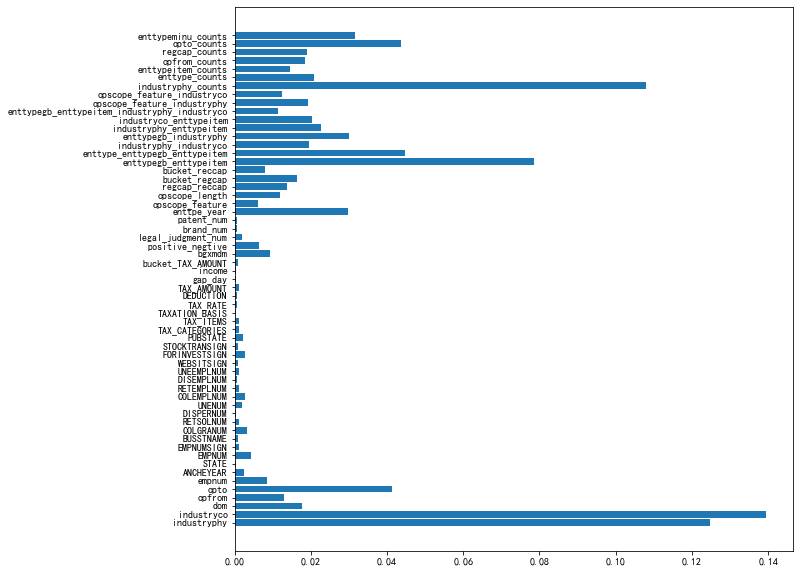

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
a = pd.DataFrame()
feature_import = rf.feature_importances_
feature_name  = x_train.columns.tolist()
plt.barh(feature_name,feature_import)
plt.show()

In [23]:
entprise_test = pd.read_csv('entprise_evaluate.csv')
dict1 = {
    'id':entprise_test.id,
    'score':result_1
}
df = pd.DataFrame(dict1)
df.score.value_counts()

0    9101
1     899
Name: score, dtype: int64

In [ ]:
entprise_test = pd.read_csv('entprise_evaluate.csv')
dict1 = {
    'id':entprise_test.id,
    'score':result_1
}
df = pd.DataFrame(dict1)
df.to_csv(r'./result/1120_1.csv', index=False)

## Catboost

In [32]:
from sklearn.metrics import auc, roc_curve,f1_score
from sklearn.model_selection import StratifiedKFold, KFold
#from catboost import CatBoostRegressor
import lightgbm as lgb
# 模型
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=100,
                              learning_rate=0.2, n_estimators=60, max_depth=5, 
                              metric='rmse', bagging_fraction = 0.8, feature_fraction = 1.0)
def stat_func(x):
    l1 = []
    for i in x:
        if i>0.5:
            a = 1
            l1.append(a)
        else:
            a = 0
            l1.append(a)
    return l1
cat_list = [3]
# 本地验证
kf = KFold(n_splits=5,shuffle=True,random_state=2020)
devscore = []
tevscore = []
count = 1
for tidx,didx in kf.split(x_train.index):
    print('************************************ {} ************************************'.format(str(count)))
    count += 1
    tf = x_train.iloc[tidx]
    df = x_train.iloc[didx]
    tt = y_train.iloc[tidx]
    dt = y_train.iloc[didx]
    lgb_train = lgb.Dataset(tf,tt,free_raw_data=False)
    lgb_eval = lgb.Dataset(df,dt,reference=lgb_train,free_raw_data=False)
    model_lgb.fit(tf,tt)
    #catr.fit(tf, tt,cat_features=cat_list)
    pre_train = model_lgb.predict(tf)
    stat_pre_train = stat_func(pre_train)
    score = f1_score(stat_pre_train,tt)
    tevscore.append(score)
    print("train F1：%s"%score)
    pre = model_lgb.predict(df)
    stat_pre = stat_func(pre)
    score = f1_score(stat_pre,dt)
    devscore.append(score)
    print("Valid F1：%s"%score)
print("Train average F1：%s"%np.mean(tevscore),"Valid average F1：%s"%np.mean(devscore))

************************************ 1 ************************************
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
train F1：0.9065015479876162
Valid F1：0.8123393316195373
************************************ 2 ************************************
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
train F1：0.9170149253731343
Valid F1：0.8284023668639054
************************************ 3 ************************************
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subs

In [ ]:
from sklearn.metrics import auc, roc_curve,f1_score,precision_score,recall_score
from sklearn.model_selection import StratifiedKFold, KFold
from catboost import CatBoostRegressor
# 模型
def makecatr():
    params = {
        "learning_rate":0.01,
        'iterations':5000,
        'depth': 5,
        'l2_leaf_reg': 3,
        'bootstrap_type':'Bernoulli',
        'od_type': 'Iter',
        'od_wait': 50,
        'random_seed': 2020,
        'allow_writing_files': False,
        'task_type':'CPU',
        'verbose':500,
        'loss_function':'RMSE',
    }
    
    catr = CatBoostRegressor(**params)
    return catr
def stat_func(x):
    l1 = []
    for i in x:
        if i>0.5:
            a = 1
            l1.append(a)
        else:
            a = 0
            l1.append(a)
    return l1
def score_fuc(p,r):
    return 2*p*r/(p+r)
cat_list = [3]
# 本地验证
kf = KFold(n_splits=5,shuffle=True,random_state=2020)
devscore = []
tevscore = []
count = 1
result_test = pd.DataFrame()
for tidx,didx in kf.split(x_train.index):
    print('************************************ {} ************************************'.format(str(count)))
    count += 1
    tf = x_train.iloc[tidx]
    df = x_train.iloc[didx]
    tt = y_train.iloc[tidx]
    dt = y_train.iloc[didx]
    catr = makecatr()
    catr.fit(tf, tt)
    pre_train = catr.predict(tf)
    stat_pre_train = stat_func(pre_train)
    p = precision_score(tt,stat_pre_train)
    r = recall_score(tt,stat_pre_train)
    score = score_fuc(p,r)
    #score = f1_score(stat_pre_train,tt)
    tevscore.append(score)
    print("train F1：%s"%score)
    pre = catr.predict(df)
    stat_pre = stat_func(pre)
    p = precision_score(dt,stat_pre)
    r = recall_score(dt,stat_pre)
    score = score_fuc(p,r)
    devscore.append(score)
    result_test[str(count-1)+"折"] = rf.predict(x_test)/5
    print("Valid F1：%s"%score)
print("Train average F1：%s"%np.mean(tevscore),"Valid average F1：%s"%np.mean(devscore))
result_test['result'] = result_test['1折']+result_test['2折']+result_test['3折']+result_test['4折']+result_test['5折']
result = result_test['result'].values
result_1 = stat_func(result)

In [ ]:
entprise_test = pd.read_csv('entprise_evaluate.csv')
dict1 = {
    'id':entprise_test.id,
    'score':result_1
}
df = pd.DataFrame(dict1)
df.score.value_counts()

In [ ]:
result_1

In [ ]:
entprise_test = pd.read_csv('entprise_evaluate.csv')
dict1 = {
    'id':entprise_test.id,
    'score':result_1
}
df = pd.DataFrame(dict1)
df.to_csv(r'1118_4.csv', index=False)

In [ ]:
from sklearn.metrics import auc, roc_curve,f1_score
from sklearn.model_selection import StratifiedKFold, KFold
#from catboost import CatBoostRegressor
import lightgbm as lgb
# 模型
params = {
        'boosting_type': 'gbdt',
        'boosting': 'dart',
        'objective': 'binary',
        'metric': 'binary_logloss',
        'learning_rate': 0.01,
        'num_leaves':25,
        'max_depth':3,
        'max_bin':10,
        'min_data_in_leaf':8,
        'feature_fraction': 0.6,
        'bagging_fraction': 1,
        'bagging_freq':0,
        'lambda_l1': 0,
        'lambda_l2': 0,
        'min_split_gain': 0
}
def stat_func(x):
    l1 = []
    for i in x:
        if i>0.5:
            a = 1
            l1.append(a)
        else:
            a = 0
            l1.append(a)
    return l1
cat_list = [3]
# 本地验证
kf = KFold(n_splits=5,shuffle=True,random_state=2020)
devscore = []
tevscore = []
count = 1
for tidx,didx in kf.split(x_train.index):
    print('************************************ {} ************************************'.format(str(count)))
    count += 1
    tf = x_train.iloc[tidx]
    df = x_train.iloc[didx]
    tt = y_train.iloc[tidx]
    dt = y_train.iloc[didx]
    lgb_train = lgb.Dataset(tf,tt,free_raw_data=False)
    lgb_eval = lgb.Dataset(df,dt,reference=lgb_train,free_raw_data=False)
    gbm  = lgb.train(params,lgb_train,num_boost_round=2000,valid_sets=lgb_eval,verbose_eval=200)
    #catr.fit(tf, tt,cat_features=cat_list)
    pre_train = gbm.predict(tf)
    stat_pre_train = stat_func(pre_train)
    score = f1_score(stat_pre_train,tt)
    tevscore.append(score)
    print("train F1：%s"%score)
    pre = gbm.predict(df)
    stat_pre = stat_func(pre)
    score = f1_score(stat_pre,dt)
    devscore.append(score)
    print("Valid F1：%s"%score)
print("Train average F1：%s"%np.mean(tevscore),"Valid average F1：%s"%np.mean(devscore))

In [ ]:
entprise_test = pd.read_csv('entprise_evaluate.csv')
dict1 = {
    'id':entprise_test.id,
    'score':pre
}
df = pd.DataFrame(dict1)
df.to_csv(r'1109_3.csv', index=False)
# 0.82877408
#0.8267

In [ ]:
def eval_score(y_test,y_pre):
    _,_,f_class,_=precision_recall_fscore_support(y_true=y_test,y_pred=y_pre,labels=[0,1],average=None)
    fper_class={'合法':f_class[0],'违法':f_class[1],'f1':f1_score(y_test,y_pre)}
    return fper_class
#
def k_fold_serachParmaters(model,train_val_data,train_val_kind):
    mean_f1=0
    mean_f1Train=0
    n_splits=5
    sk = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=2020)
    for train, test in sk.split(train_val_data, train_val_kind):
        x_train = train_val_data.iloc[train]
        y_train = train_val_kind.iloc[train]
        x_test = train_val_data.iloc[test]
        y_test = train_val_kind.iloc[test]

        model.fit(x_train, y_train)
        pred = model.predict(x_test)
        fper_class =  eval_score(y_test,pred)
        mean_f1+=fper_class['f1']/n_splits
        #print(fper_class)
        
        pred_Train = model.predict(x_train)
        fper_class_train =  eval_score(y_train,pred_Train)
        mean_f1Train+=fper_class_train['f1']/n_splits
    #print('mean valf1:',mean_f1)
    #print('mean trainf1:',mean_f1Train)
    return mean_f1

In [ ]:
rf = RandomForestClassifier(oob_score=True, random_state=2020,
            n_estimators= 15,max_depth=19,min_samples_split=12)
k_fold_serachParmaters(rf,x_train,y_train)

In [ ]:
pre1 = rf.predict(x_test)

In [ ]:
entprise_test = pd.read_csv('entprise_evaluate.csv')
dict1 = {
    'id':entprise_test.id,
    'score':pre1
}
df = pd.DataFrame(dict1)
df.to_csv(r'1109_1.csv', index=False)

In [ ]:
n_estimators_list = []
for i in range(60,70):
    n_estimators_list.append(int(i))
min_samples_split_list = []
for i in range(12,30):
    min_samples_split_list.append(i)
max_depth_list = []
for i in range(19,30):
    max_depth_list.append(i)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve, GridSearchCV

def search_param(n_estimators,max_depth,min_samples_split):
    rf = RandomForestClassifier(oob_score=True, random_state=2020,
                    n_estimators= n_estimators,max_depth=max_depth,min_samples_split=min_samples_split)
    mean_f1=k_fold_serachParmaters(rf,x_train,y_train)
    return mean_f1

#搜索最佳参数
param=[]
best=0
for n_estimators in n_estimators_list:
    print('n_estimators:',n_estimators)
    for min_samples_split in min_samples_split_list:
        for max_depth in max_depth_list:
            mean_f1=search_param(n_estimators,max_depth,min_samples_split)
            if mean_f1>best:
                param=[n_estimators,min_samples_split,max_depth]
                best=mean_f1
                print(param,best)

In [ ]:
n_estimators = 15
min_samples_split = 12
max_depth = 19

In [ ]:
x_train.enttypeitem.unique()

In [ ]:
x_train.regcap.value_counts()

In [ ]:
x_train.reccap[0]

In [ ]:
x_train.info()

In [ ]:
feas_importances_dict = {col:importance for col,importance in zip(list(x_train.columns),list(catr.feature_importances_))}
print('Feature importances:\n',feas_importances_dict)

In [ ]:
feas_importances_dict = {col:importance for col,importance in zip(list(x_train.columns),list(catr.feature_importances_))}
print('Feature importances:\n',feas_importances_dict)

In [ ]:
'bucket_regcap_reccap'